<a href="https://colab.research.google.com/github/wedexyz/eeg-/blob/main/trainLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import time

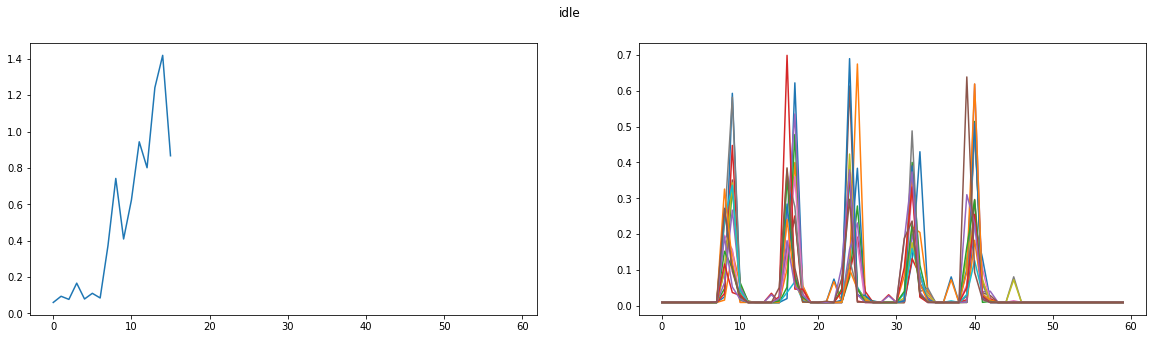

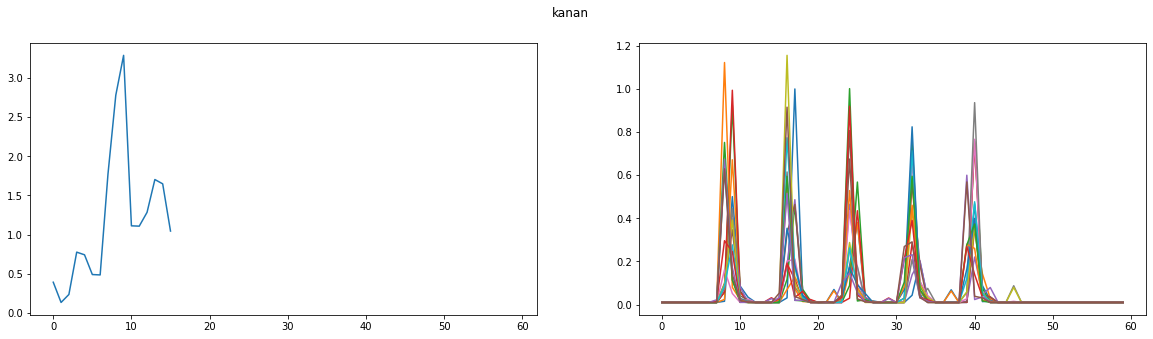

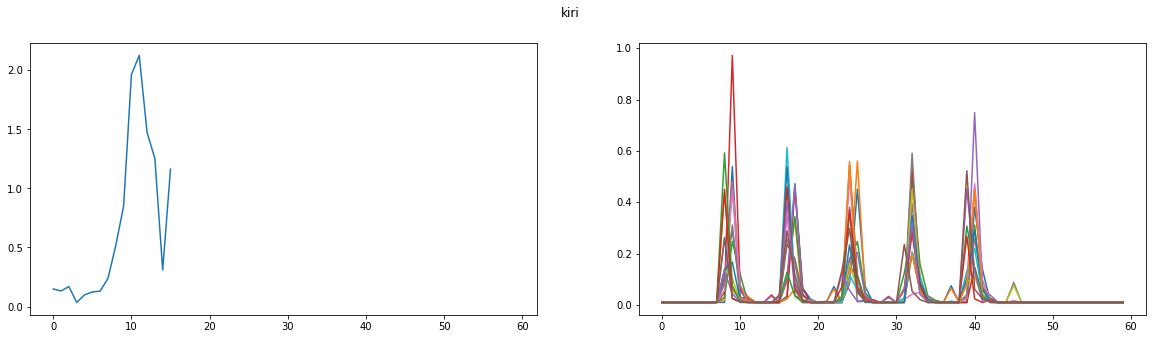

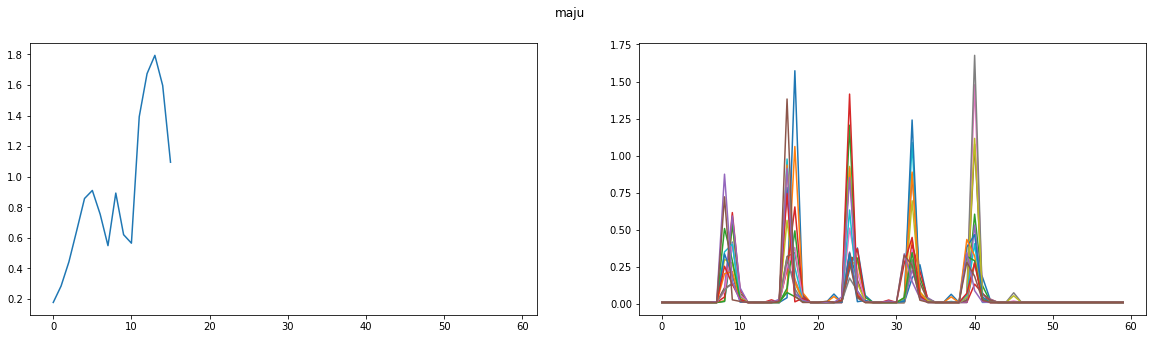

In [ ]:
idle = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/idle/1604314994.npy")
kanan = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/kanan/1604315166.npy")
kiri = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/kiri/1604315112.npy")
maju = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/maju/1604315056.npy")

fig, (ax1, ax2) =  plt.subplots( ncols=2, sharex=True,figsize=(20, 5))
fig.suptitle('idle')
ax1.plot(idle[0][16])
ax2.plot(idle[175])

fig, (ax3, ax4) =  plt.subplots( ncols=2, sharex=True,figsize=(20, 5))
fig.suptitle('kanan')
ax3.plot(kanan[0][16])
ax4.plot(kanan[175])

fig, (ax5, ax6) =  plt.subplots( ncols=2, sharex=True,figsize=(20, 5))
fig.suptitle('kiri')
ax5.plot(kiri[0][16])
ax6.plot(kiri[175])

fig, (ax7, ax8) =  plt.subplots( ncols=2, sharex=True,figsize=(20, 5))
fig.suptitle('maju')
ax7.plot(maju[0][16])
ax8.plot(maju[175])



plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ACTIONS = ["kiri", "maju","idle","kanan"]
reshape = (-1,16, 60)


def create_data(starting_dir="=/content/drive/My Drive/Colab Notebooks/data_baru"):
    training_data = {}
    for action in ACTIONS:
        if action not in training_data:
            training_data[action] = []
        data_dir = os.path.join(starting_dir,action)
        for item in os.listdir(data_dir):
            data = np.load(os.path.join(data_dir, item))
            for item in data:
                training_data[action].append(item)

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)

    for action in ACTIONS:
        np.random.shuffle(training_data[action])  
        training_data[action] = training_data[action][:min(lengths)]

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)
    combined_data = []
    for action in ACTIONS:
        for data in training_data[action]:
            if action == "kiri":
                combined_data.append([data, [1, 0, 0,0]])
            elif action == "maju":
                combined_data.append([data, [0, 1, 0, 0]])
            elif action == "idle":
                combined_data.append([data, [0, 0, 1, 0]])
            elif action == "kanan":
                combined_data.append([data, [0, 0, 0, 1]])

    np.random.shuffle(combined_data)
    print("length:",len(combined_data))
    return combined_data


In [ ]:
print("creating training data")
traindata = create_data(starting_dir="/content/drive/My Drive/Colab Notebooks/data_baru")
train_X = []
train_y = []
for X, y in traindata:
    train_X.append(X)
    train_y.append(y)



creating training data
[1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000]
length: 4000


In [ ]:
print("creating testing data")
testdata = create_data(starting_dir="/content/drive/My Drive/Colab Notebooks/data_baru")
test_X = []
test_y = []
for X, y in testdata:
    test_X.append(X)
    test_y.append(y)
print(len(train_X))
print(len(test_X))
print(np.array(train_X).shape)


train_X = np.array(train_X).reshape(reshape)
test_X = np.array(test_X).reshape(reshape)

train_y = np.array(train_y)
test_y = np.array(test_y)




creating testing data
[1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000]
length: 4000
4000
4000
(4000, 60, 16)


In [ ]:

model3 = Sequential()
model3.add(LSTM(64,input_shape=train_X.shape[1:], return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64,input_shape=train_X.shape[1:], return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64,input_shape=train_X.shape[1:], return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64))
model3.add(Dense(4, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0001), metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 64)            32000     
_________________________________________________________________
dropout (Dropout)            (None, 16, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                3

In [ ]:
epochs = 1000
batch_size = 32
for epoch in range(epochs):
    model3.fit(train_X, train_y, batch_size=batch_size, epochs=1, validation_data=(test_X, test_y))
    score = model3.evaluate(test_X, test_y, batch_size=batch_size)
    MODEL_NAME = f"LSTM_model/{round(score[1]*100,2)}-acc-64x3-batch-norm-{epoch}epoch-{int(time.time())}-loss-{round(score[0],2)}.model"
history = model3.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_X, test_y))
model3.save(MODEL_NAME)


125/125 [==============================] - 1s 5ms/step - loss: 0.2012 - accuracy: 0.7595
Epoch 1/1000
125/125 [==============================] - 2s 15ms/step - loss: 0.2145 - accuracy: 0.7335 - val_loss: 0.1989 - val_accuracy: 0.7640
Epoch 2/1000
125/125 [==============================] - 2s 15ms/step - loss: 0.2147 - accuracy: 0.7477 - val_loss: 0.2058 - val_accuracy: 0.7570
Epoch 3/1000
125/125 [==============================] - 2s 14ms/step - loss: 0.2182 - accuracy: 0.7365 - val_loss: 0.1992 - val_accuracy: 0.7602
Epoch 4/1000
125/125 [==============================] - 2s 15ms/step - loss: 0.2186 - accuracy: 0.7390 - val_loss: 0.2035 - val_accuracy: 0.7520
Epoch 5/1000
125/125 [==============================] - 2s 14ms/step - loss: 0.2384 - accuracy: 0.7237 - val_loss: 0.2260 - val_accuracy: 0.7408
Epoch 6/1000
125/125 [==============================] - 2s 14ms/step - loss: 0.2238 - accuracy: 0.7335 - val_loss: 0.2004 - val_accuracy: 0.7628
Epoch 7/1000
125/125 [===================

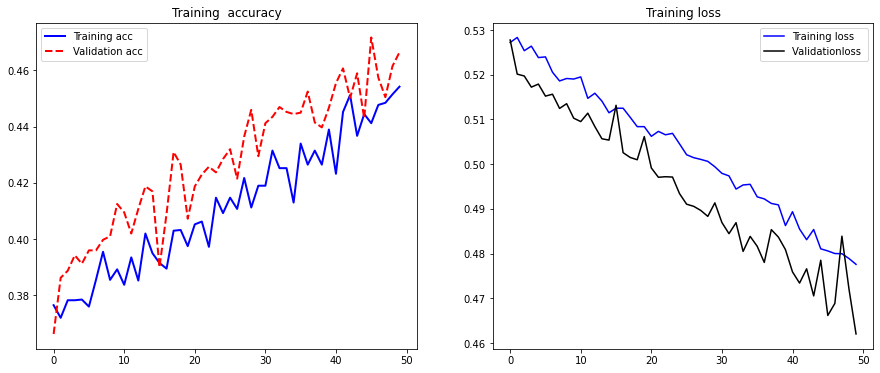

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
    plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
    plt.title('Training  accuracy')
    plt.legend()
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'k', label='Validationloss ')
    plt.title('Training loss')
    plt.legend()
 
    plt.show()
plot_training_history(history)